## Importing Packages

In [10]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

import numpy as np
import pandas as pd
import cmdstanpy 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import json
from utils.random import random_rdm_2A
from utils.utils import get_dfs, calculate_waic, bci, plot_mean_posterior
import ipywidgets as widgets

## Choose Model

#### roots and global variables

In [11]:
root = "../"
plots_root = "Results/hierarchical/Plots/"
datasets_root = root + "Datasets/"
behavioural_data_root = datasets_root +  "behavioral_data/selected_data/" 
stan_files_root = root +  "models/stan/" 
saved_models_root = "Results/hierarchical/stan_results/"
dataset_path = datasets_root + "AI Models Results/fastText_FC.csv"


## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [12]:
word_nword_df = pd.read_csv(dataset_path, header=None,
                            names =["string", "freq",  "label", "zipf",
                                    "category", "word_prob", "non_word_prob"])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,Ipe's,0,0,0.000000,NW,6.484266e-08,9.999998e-01
1,toothcamb,0,0,0.000000,NW,4.641062e-05,9.999536e-01
2,flicks,702,1,2.935287,LF,9.993498e-01,6.502719e-04
3,Samoar,0,0,0.000000,NW,1.966545e-06,9.999980e-01
4,lastened,0,0,0.000000,NW,1.107923e-04,9.998892e-01
...,...,...,...,...,...,...,...
74312,drased,0,0,0.000000,NW,6.662523e-05,9.999334e-01
74313,exorcism,238,1,3.274105,HF,9.999999e-01,7.543648e-08
74314,pobs,0,0,0.000000,NW,1.563252e-07,9.999999e-01
74315,undemonstrative,3,1,1.592864,LF,9.999452e-01,5.486609e-05


In [13]:
# Reading LDT Data
behavioural_df = pd.read_csv(behavioural_data_root + "LDT_data.csv",
                             header=None,
                             names=["accuracy", "rt", "string", "response",
                                    "participant", "minRT", "participant_id"])
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on="string", how="left").dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["freq", "participant"], axis=1)

In [14]:
# Reducing size of dataframe for testing purposes
behavioural_df = behavioural_df.loc[behavioural_df["participant_id"].isin(np.arange(2))]

In [15]:
behavioural_df

,accuracy,rt,string,response,minRT,participant_id,label,zipf,category,word_prob,non_word_prob
0,1,0.422,sand,1,0.422,1,1.0,4.307194,HF,0.999509,0.000491
1,1,0.462,textbook,1,0.422,1,1.0,3.344913,HF,0.999996,0.000003
2,0,0.490,carmed,1,0.422,1,0.0,0.000000,NW,0.000087,0.999913
3,1,0.503,pain,1,0.422,1,1.0,4.990457,HF,0.999988,0.000012
4,1,0.513,technical,1,0.422,1,1.0,3.916116,HF,0.999640,0.000360
...,...,...,...,...,...,...,...,...,...,...,...
367,1,1.340,creatoon's,0,0.422,1,0.0,0.000000,NW,0.000078,0.999921
368,1,1.372,ricochet,1,0.422,1,1.0,2.689774,LF,0.999939,0.000061
369,1,1.392,transformation,1,0.422,1,1.0,3.300434,HF,0.999947,0.000053
370,1,1.423,gompiles,0,0.422,1,0.0,0.000000,NW,0.000007,0.999993


In [16]:
def plot_pp_quantiles(model_names=['RDM_cd', 'ANN-RDM_s_am_BERT', 'ANN-RDM_s_am_FT'], labels=['RDM', 'ANN-EAM 4', 'ANN-EAM 2']):
    quantiles = [.1, .3, .5, .7, .9]
    fig, axes = plt.subplots(1,3 , figsize=(25,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    
    axes[0].set_title("HF quantiles", fontweight="bold", size=15)
    axes[1].set_title("LF quantiles", fontweight="bold", size=15)
    axes[2].set_title("NW quantiles", fontweight="bold", size=15)
    
    HF_quantile_ex = behavioural_df.loc[behavioural_df['category'] == 'HF']["rt"].quantile(quantiles)
    LF_quantile_ex = behavioural_df.loc[behavioural_df['category'] == 'LF']["rt"].quantile(quantiles)
    NW_quantile_ex = behavioural_df.loc[behavioural_df['category'] == 'NW']["rt"].quantile(quantiles)
    
    
    axes[0].scatter(quantiles, HF_quantile_ex, color="black", s=50)
    axes[1].scatter(quantiles, LF_quantile_ex, color="black", s=50)
    axes[2].scatter(quantiles, NW_quantile_ex, color="black", s=50)
    
    for index, model_name in enumerate(model_names):
        with open(f'Results/Simulations/{model_name}.npy', 'rb') as f:
            pp_rt = np.load(f)
            pp_response = np.load(f)
        
        # Predicted Data
        tmp1 = pd.DataFrame(pp_rt,
                            index=pd.Index(np.arange(1, len(pp_rt)+1), name="sample"),
                            columns=pd.MultiIndex.from_product((["rt"],
                                                                np.arange(pp_rt.shape[1])),
                                                                names=["variable", "trial"]))
        tmp2 = pd.DataFrame(pp_response,
                            index=pd.Index(np.arange(1, len(pp_response)+1), name="sample"),
                            columns=pd.MultiIndex.from_product((["response"],
                                                                np.arange(pp_response.shape[1])),
                                                                       names=["variable", "trial"]))
        predicted_data = pd.concat((tmp1, tmp2), axis=1)
        
        pred_HF_trials = predicted_data['rt'][behavioural_df.loc[behavioural_df['category'] == 'HF'].index]
        pred_LF_trials = predicted_data['rt'][behavioural_df.loc[behavioural_df['category'] == 'LF'].index]
        pred_NW_trials = predicted_data['rt'][behavioural_df.loc[behavioural_df['category'] == 'NW'].index]
        
        # predicted data quantiles (for each sample)
        HF_quantile_pred = pred_HF_trials.quantile(quantiles, axis=1).T
        LF_quantile_pred = pred_LF_trials.quantile(quantiles, axis=1).T
        NW_quantile_pred = pred_NW_trials.quantile(quantiles, axis=1).T

        # predicted data quantiles bci
        HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
        LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
        NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])
        
        axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1], alpha=0.3, label=labels[index])

        axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1], alpha=0.3, label=labels[index])

        axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1], alpha=0.3, label=labels[index])
        
    
    for ax in axes:
        ax.set_xlabel("Quantiles", fontsize=15)
        ax.set_ylabel("RTs upper boundary", fontsize=15)
        for tick in ax.xaxis.get_major_ticks():
                tick.label1.set_fontsize(13)
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(13) 
            
    axes[0].legend(loc = 'upper left', fontsize=12, facecolor='white', edgecolor='black')
    axes[1].legend(loc = 'upper left', fontsize=12, facecolor='white', edgecolor='black')
    axes[2].legend(loc = 'upper left', fontsize=12, facecolor='white', edgecolor='black')
        
    # plt.show()
    plt.savefig("./Results/quantiles.pdf")

In [17]:
plt.style.use("ggplot");
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["steelblue", "khaki", "tomato"]) 

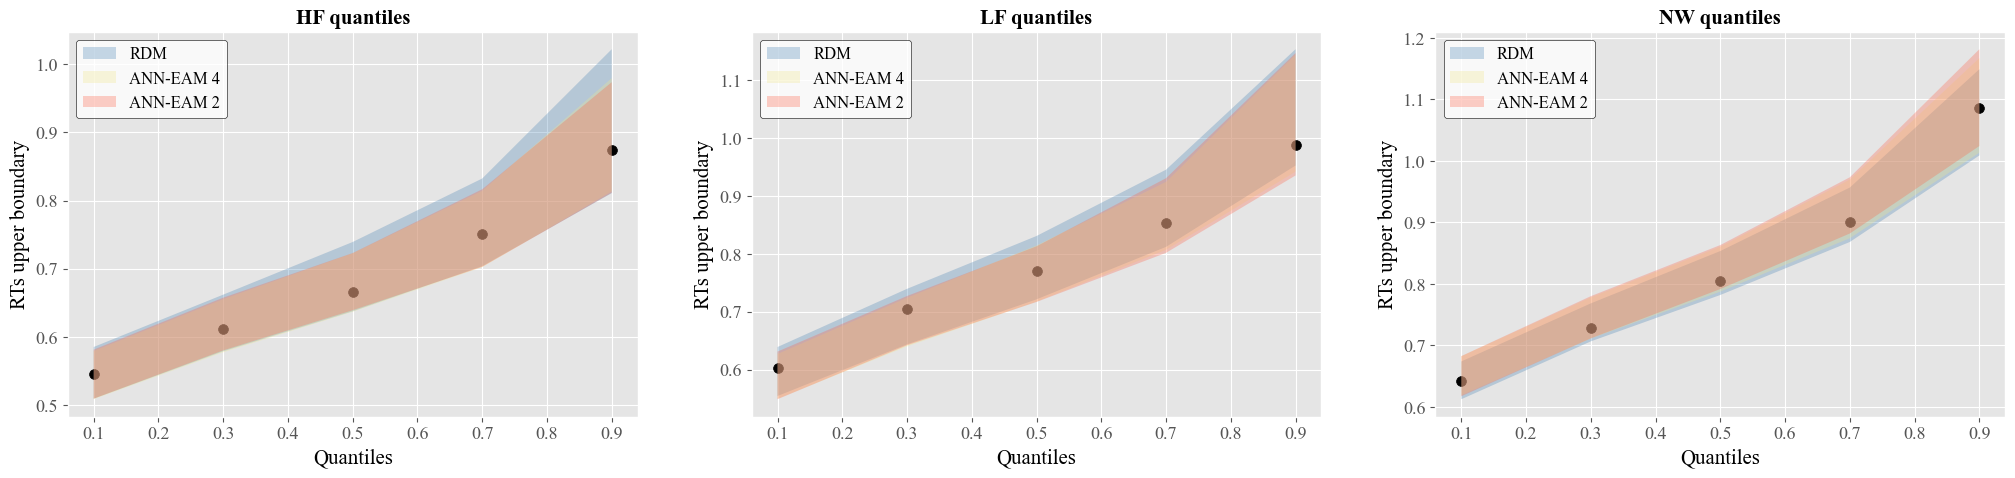

In [18]:
plot_pp_quantiles()